## Импорт библиотек

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from optuna.samplers import TPESampler
from bayes_opt import BayesianOptimization


## Загрузка и исправление данных

In [95]:
df  = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
df.set_index("Person ID", inplace=True)
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
Person ID,,,,,,,,,,,,
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...
370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


In [96]:
print("Размер датасета:", df.shape)
print("Пропущенные значения:")
print(df.isnull().sum())
print(df['Sleep Disorder'].unique())


Размер датасета: (374, 12)
Пропущенные значения:
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64
[nan 'Sleep Apnea' 'Insomnia']


In [97]:
# Заполним пропуски в поле нарушений сна
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('Good')
print("Пропущенные значения:")
print(df.isnull().sum())
print(df['Sleep Disorder'].unique())


Пропущенные значения:
Gender                     0
Age                        0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
BMI Category               0
Blood Pressure             0
Heart Rate                 0
Daily Steps                0
Sleep Disorder             0
dtype: int64
['Good' 'Sleep Apnea' 'Insomnia']


In [98]:
# Разделяем значения в столбце 'Blood Pressure' на две части, создав 2 числовых столбца
df[['Blood Pressure upper', 'Blood Pressure lower']] = df['Blood Pressure'].str.split('/', expand=True)
df['Blood Pressure upper'] = pd.to_numeric(df['Blood Pressure upper'], errors='coerce')
df['Blood Pressure lower'] = pd.to_numeric(df['Blood Pressure lower'], errors='coerce')
df.drop(columns=['Blood Pressure'], inplace=True)
df.dtypes

Gender                      object
Age                          int64
Occupation                  object
Sleep Duration             float64
Quality of Sleep             int64
Physical Activity Level      int64
Stress Level                 int64
BMI Category                object
Heart Rate                   int64
Daily Steps                  int64
Sleep Disorder              object
Blood Pressure upper         int64
Blood Pressure lower         int64
dtype: object

In [99]:
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Blood Pressure upper,Blood Pressure lower
Person ID,,,,,,,,,,,,,
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,Good,126,83
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,Good,125,80
3,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,Good,125,80
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
5,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea,140,95
371,Female,59,Nurse,8.0,9,75,3,Overweight,68,7000,Sleep Apnea,140,95
372,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea,140,95


## EDA

In [100]:
df.describe().T.style.background_gradient(cmap='YlOrRd')


,count,mean,std,min,25%,50%,75%,max
Age,374.000000,42.184492,8.673133,27.000000,35.250000,43.000000,50.000000,59.000000
Sleep Duration,374.000000,7.132086,0.795657,5.800000,6.400000,7.200000,7.800000,8.500000
Quality of Sleep,374.000000,7.312834,1.196956,4.000000,6.000000,7.000000,8.000000,9.000000
Physical Activity Level,374.000000,59.171123,20.830804,30.000000,45.000000,60.000000,75.000000,90.000000
Stress Level,374.000000,5.385027,1.774526,3.000000,4.000000,5.000000,7.000000,8.000000
Heart Rate,374.000000,70.165775,4.135676,65.000000,68.000000,70.000000,72.000000,86.000000
Daily Steps,374.000000,6816.844920,1617.915679,3000.000000,5600.000000,7000.000000,8000.000000,10000.000000
Blood Pressure upper,374.000000,128.553476,7.748118,115.000000,125.000000,130.000000,135.000000,142.000000
Blood Pressure lower,374.000000,84.649733,6.161611,75.000000,80.000000,85.000000,90.000000,95.000000


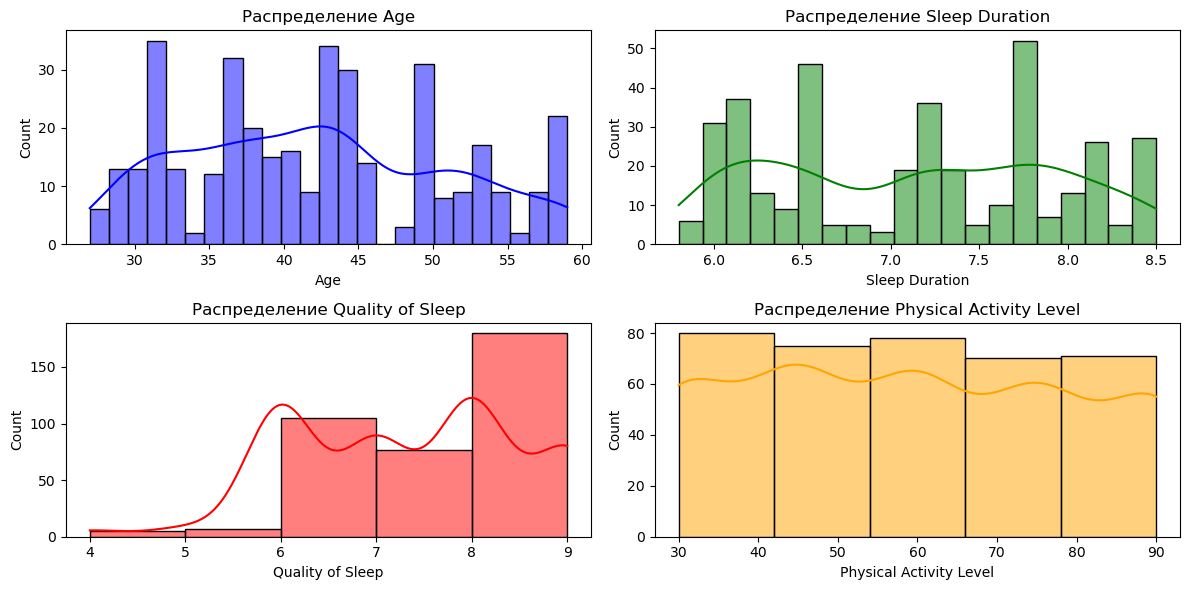

In [101]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(df['Age'], bins=25, kde=True, color='blue')
plt.title('Распределение Age')

plt.subplot(2, 2, 2)
sns.histplot(df['Sleep Duration'], bins=20, kde=True, color='green')
plt.title('Распределение Sleep Duration')

plt.subplot(2, 2, 3)
sns.histplot(df['Quality of Sleep'], bins=5, kde=True, color='red')
plt.title('Распределение Quality of Sleep')

plt.subplot(2, 2, 4)
sns.histplot(df['Physical Activity Level'], bins=5, kde=True, color='orange')
plt.title('Распределение Physical Activity Level')

plt.tight_layout()
plt.show()


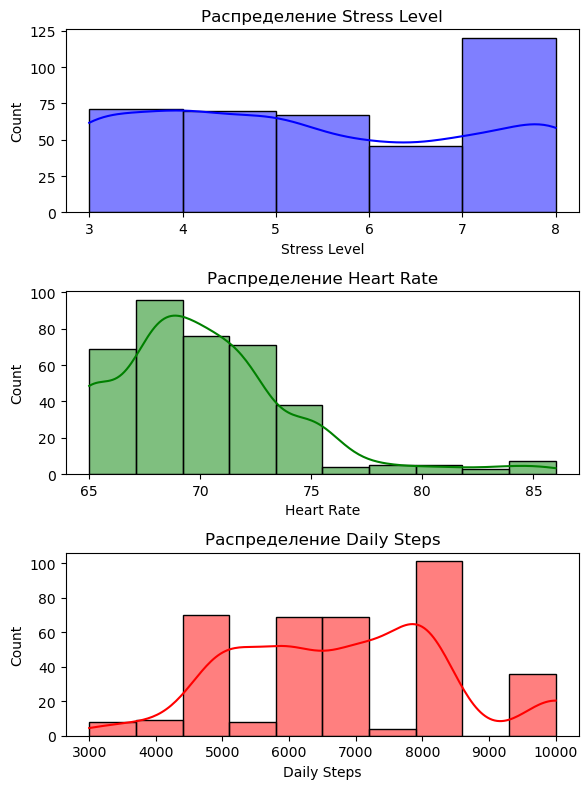

In [102]:
plt.figure(figsize=(6, 8))

plt.subplot(3, 1, 1)
sns.histplot(df['Stress Level'], bins=5, kde=True, color='blue')
plt.title('Распределение Stress Level')

plt.subplot(3, 1, 2)
sns.histplot(df['Heart Rate'], bins=10, kde=True, color='green')
plt.title('Распределение Heart Rate')

plt.subplot(3, 1, 3)
sns.histplot(df['Daily Steps'], bins=10, kde=True, color='red')
plt.title('Распределение Daily Steps')

plt.tight_layout()
plt.show()


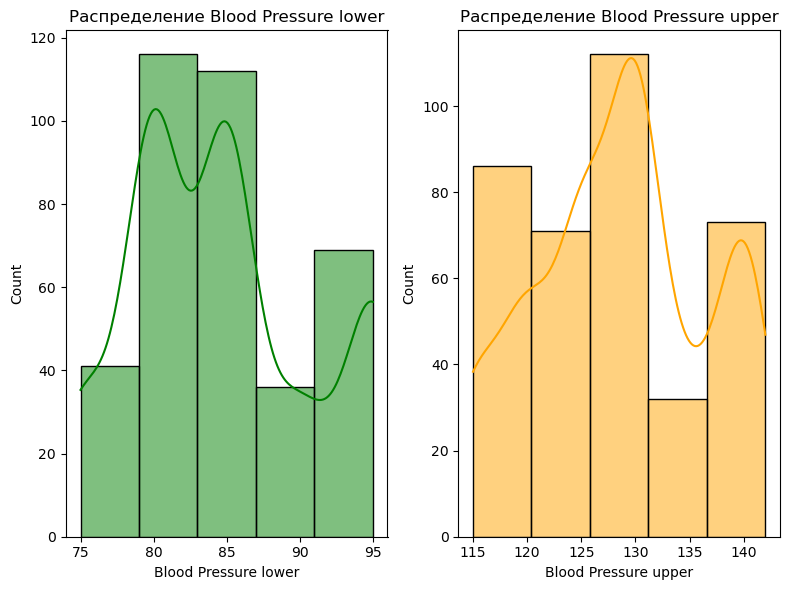

In [103]:
plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['Blood Pressure lower'], bins=5, kde=True, color='green')
plt.title('Распределение Blood Pressure lower')

plt.subplot(1, 2, 2)
sns.histplot(df['Blood Pressure upper'], bins=5, kde=True, color='orange')
plt.title('Распределение Blood Pressure upper')

plt.tight_layout()
plt.show()


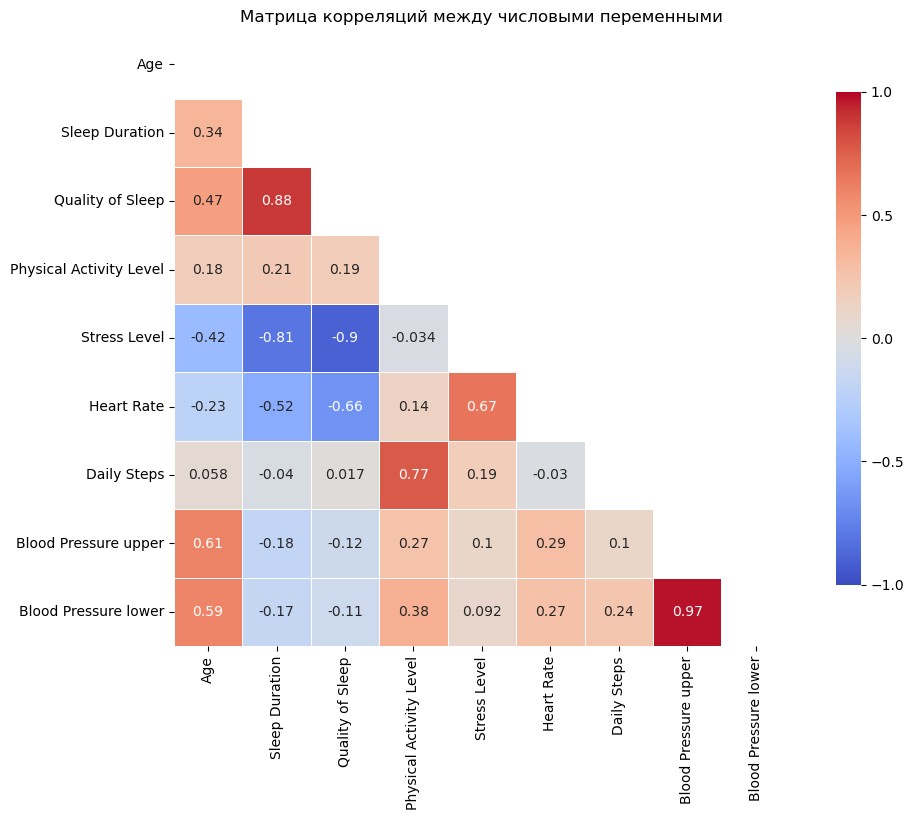

In [104]:
df_numeric = df.select_dtypes(include=['number']).copy()

correlation_matrix = df_numeric.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0, 
            square=True, linewidths=.5, annot_kws={"size": 10}, 
            cbar_kws={"shrink": 0.8, "orientation": "vertical", "ticks": [-1, -0.5, 0, 0.5, 1]})
plt.title('Матрица корреляций между числовыми переменными')
plt.show()


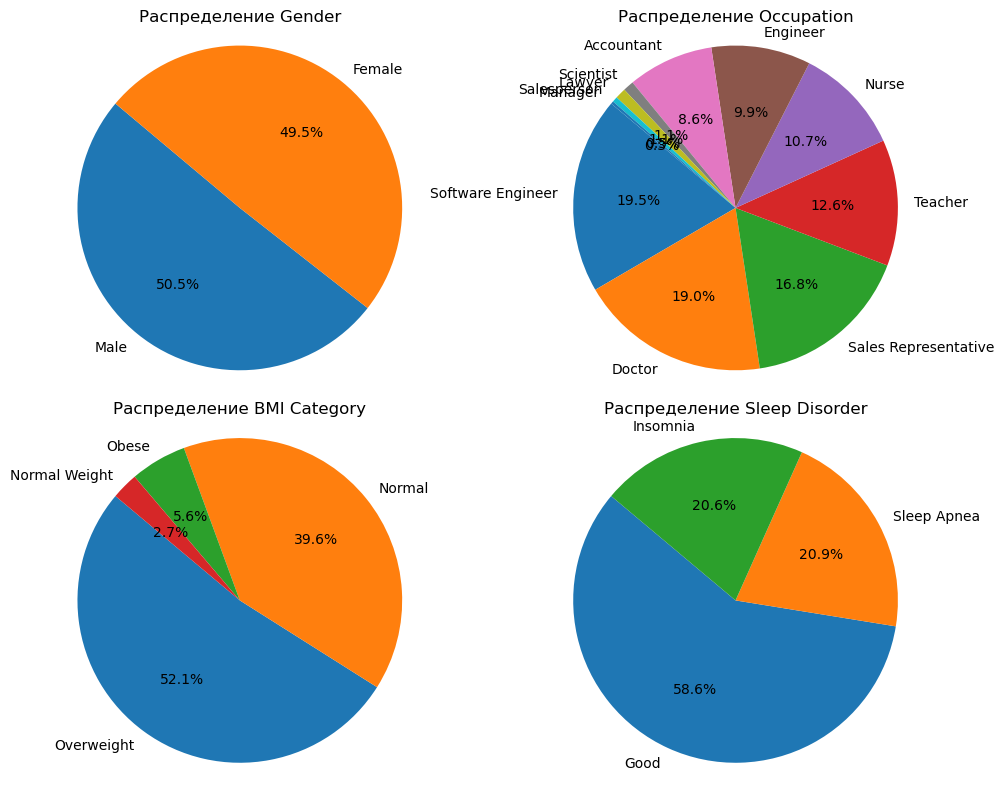

In [105]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.pie(df['Gender'].value_counts(), labels=df['Gender'].unique(), 
autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title('Распределение Gender')

plt.subplot(2, 2, 2)
plt.pie(df['Occupation'].value_counts(), labels=df['Occupation'].unique(), 
autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title('Распределение Occupation')

plt.subplot(2, 2, 3)
plt.pie(df['BMI Category'].value_counts(), labels=df['BMI Category'].unique(), 
autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title('Распределение BMI Category')

plt.subplot(2, 2, 4)
plt.pie(df['Sleep Disorder'].value_counts(), labels=df['Sleep Disorder'].unique(), 
autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title('Распределение Sleep Disorder')

plt.tight_layout()
plt.show()


## Преобразование категориальных переменных

In [109]:
# Пол
df_gender_dummies = pd.get_dummies(df['Gender'], prefix='Gender')
df = pd.concat([df, df_gender_dummies], axis=1)
df = df.drop(columns=['Gender'])

# BMI Category
df_BMI_Category = pd.get_dummies(df['BMI Category'], prefix='BMI')
df = pd.concat([df, df_BMI_Category], axis=1)
df = df.drop(columns=['BMI Category'])

# Нарушения сна
df_Sleep_Disorder = pd.get_dummies(df['Sleep Disorder'], prefix='Sleep')
df = pd.concat([df, df_Sleep_Disorder], axis=1)
df = df.drop(columns=['Sleep Disorder'])

# Профессия
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['Occupation'])
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
df = pd.concat([df, df_tfidf], axis=1)
df = df.drop(columns=['Occupation'])


In [110]:
df = df.dropna()
print("Размер датасета:", df.shape)
print("Пропущенные значения:")
print(df.isnull().sum())
df

Размер датасета: (373, 30)
Пропущенные значения:
Age                        0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
Heart Rate                 0
Daily Steps                0
Blood Pressure upper       0
Blood Pressure lower       0
Gender_Female              0
Gender_Male                0
BMI_Normal                 0
BMI_Normal Weight          0
BMI_Obese                  0
BMI_Overweight             0
Sleep_Good                 0
Sleep_Insomnia             0
Sleep_Sleep Apnea          0
accountant                 0
doctor                     0
engineer                   0
lawyer                     0
manager                    0
nurse                      0
representative             0
sales                      0
salesperson                0
scientist                  0
software                   0
teacher                    0
dtype: int64


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Blood Pressure upper,Blood Pressure lower,Gender_Female,...,engineer,lawyer,manager,nurse,representative,sales,salesperson,scientist,software,teacher
1,27.0,6.1,6.0,42.0,6.0,77.0,4200.0,126.0,83.0,False,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
2,28.0,6.2,6.0,60.0,8.0,75.0,10000.0,125.0,80.0,False,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,28.0,6.2,6.0,60.0,8.0,75.0,10000.0,125.0,80.0,False,...,0.000000,0.0,0.0,0.0,0.707107,0.707107,0.0,0.0,0.000000,0.0
4,28.0,5.9,4.0,30.0,8.0,85.0,3000.0,140.0,90.0,False,...,0.000000,0.0,0.0,0.0,0.707107,0.707107,0.0,0.0,0.000000,0.0
5,28.0,5.9,4.0,30.0,8.0,85.0,3000.0,140.0,90.0,False,...,0.453727,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.891141,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,59.0,8.1,9.0,75.0,3.0,68.0,7000.0,140.0,95.0,True,...,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
370,59.0,8.1,9.0,75.0,3.0,68.0,7000.0,140.0,95.0,True,...,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
371,59.0,8.0,9.0,75.0,3.0,68.0,7000.0,140.0,95.0,True,...,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
372,59.0,8.1,9.0,75.0,3.0,68.0,7000.0,140.0,95.0,True,...,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0


## Создание новых признаков

In [112]:
# Соотношение физической активности и уровня стресса
df.loc[:, 'Activity_to_Stress_Ratio'] = df['Physical Activity Level'] / (df['Stress Level'] + 1)

# Комбинированный признак кровяного давления
df.loc[:, 'Blood_Pressure_Ratio'] = df['Blood Pressure upper'] / df['Blood Pressure lower']

# Среднее артериальное давление (MAP) 
df.loc[:, 'MAP'] = (df['Blood Pressure upper'] + 2 * df['Blood Pressure lower']) / 3

# Индекс массы тела и уровень стресса
df.loc[:, 'BMI_and_Stress'] = df['BMI_Normal'] + df['BMI_Normal Weight'] + df['BMI_Overweight'] + df['BMI_Obese'] + df['Stress Level']


In [114]:
# Числовые признаки для создания полноминальных признаков
numeric_features = df[['Age', 'Sleep Duration', 'Quality of Sleep', 
                       'Physical Activity Level', 'Stress Level', 'Heart Rate', 
                       'Daily Steps', 'Blood Pressure upper', 'Blood Pressure lower']]

# Степень полинома degree=2 - то будут созданы все возможные признаки второй степени, включая взаимодействие между исходными признаками
# interaction_only (False) - будут создаваться как признаки взаимодействий между признаками, так и признаки более высоких степеней (квадраты, кубы)
# include_bias (False) все признаки будут созданы только на основе входных данных и их взаимодействий
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

poly_features = poly.fit_transform(numeric_features)
poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(numeric_features.columns))
df = pd.concat([df, poly_features_df], axis=1)


In [125]:
# После генерации полиноминальных признаков некоторые поля могли задублироваться, избавляемся от них
df = df.loc[:, ~df.columns.duplicated()]
duplicates = df.columns[df.columns.duplicated()].unique()
if len(duplicates) > 0:
    print(f'Найденные дублирующиеся столбцы: {duplicates}')
else:
    print('Дублирующихся столбцов нет.')
    

Дублирующихся столбцов нет.


In [126]:
df = df.dropna()
print("Размер датасета:", df.shape)
print("Пропущенные значения:")
print(df.isnull().sum())
df


Размер датасета: (372, 79)
Пропущенные значения:
Age                                          0
Sleep Duration                               0
Quality of Sleep                             0
Physical Activity Level                      0
Stress Level                                 0
                                            ..
Daily Steps Blood Pressure upper             0
Daily Steps Blood Pressure lower             0
Blood Pressure upper^2                       0
Blood Pressure upper Blood Pressure lower    0
Blood Pressure lower^2                       0
Length: 79, dtype: int64


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Blood Pressure upper,Blood Pressure lower,Gender_Female,...,Heart Rate^2,Heart Rate Daily Steps,Heart Rate Blood Pressure upper,Heart Rate Blood Pressure lower,Daily Steps^2,Daily Steps Blood Pressure upper,Daily Steps Blood Pressure lower,Blood Pressure upper^2,Blood Pressure upper Blood Pressure lower,Blood Pressure lower^2
1,27.0,6.1,6.0,42.0,6.0,77.0,4200.0,126.0,83.0,False,...,5625.0,750000.0,9375.0,6000.0,100000000.0,1250000.0,800000.0,15625.0,10000.0,6400.0
2,28.0,6.2,6.0,60.0,8.0,75.0,10000.0,125.0,80.0,False,...,5625.0,750000.0,9375.0,6000.0,100000000.0,1250000.0,800000.0,15625.0,10000.0,6400.0
3,28.0,6.2,6.0,60.0,8.0,75.0,10000.0,125.0,80.0,False,...,7225.0,255000.0,11900.0,7650.0,9000000.0,420000.0,270000.0,19600.0,12600.0,8100.0
4,28.0,5.9,4.0,30.0,8.0,85.0,3000.0,140.0,90.0,False,...,7225.0,255000.0,11900.0,7650.0,9000000.0,420000.0,270000.0,19600.0,12600.0,8100.0
5,28.0,5.9,4.0,30.0,8.0,85.0,3000.0,140.0,90.0,False,...,7225.0,255000.0,11900.0,7650.0,9000000.0,420000.0,270000.0,19600.0,12600.0,8100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,59.0,8.0,9.0,75.0,3.0,68.0,7000.0,140.0,95.0,True,...,4624.0,476000.0,9520.0,6460.0,49000000.0,980000.0,665000.0,19600.0,13300.0,9025.0
369,59.0,8.1,9.0,75.0,3.0,68.0,7000.0,140.0,95.0,True,...,4624.0,476000.0,9520.0,6460.0,49000000.0,980000.0,665000.0,19600.0,13300.0,9025.0
370,59.0,8.1,9.0,75.0,3.0,68.0,7000.0,140.0,95.0,True,...,4624.0,476000.0,9520.0,6460.0,49000000.0,980000.0,665000.0,19600.0,13300.0,9025.0
371,59.0,8.0,9.0,75.0,3.0,68.0,7000.0,140.0,95.0,True,...,4624.0,476000.0,9520.0,6460.0,49000000.0,980000.0,665000.0,19600.0,13300.0,9025.0


## Подготовка данных к обучению моделей

In [144]:
# В качестве таргета возьмём частоту пульса
X = df.drop(columns=['Heart Rate'])
y = df['Heart Rate']

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Размер X_train: {len(X_train)}")
print(f"Размер X_test: {len(X_test)}")
print(f"Размер y_train: {len(y_train)}")
print(f"Размер y_test: {len(y_test)}")


Размер X_train: 297
Размер X_test: 75
Размер y_train: 297
Размер y_test: 75


## Обучение модели GradientBoostingRegressor


In [145]:
model = GradientBoostingRegressor(
    n_estimators=100,   
    learning_rate=0.1,   
    max_depth=3,        
    random_state=42    
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE на тестовых данных: {rmse:.2f}')
print(f"R² тестовых данных: {r2:.2f}")


RMSE на тестовых данных: 0.79
R² тестовых данных: 0.97


## Отбор признаков

### С помощью SelectKBest

In [156]:
# Будет выбрано и сохранено только 5 наиболее значимых для модели (k=5)
selector_kbest = SelectKBest(score_func=f_regression, k=5)
selector_kbest.fit(X_train, y_train)

X_train_kbest = selector_kbest.transform(X_train)
X_test_kbest = selector_kbest.transform(X_test)

model_kbest = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_kbest.fit(X_train_kbest, y_train)

y_pred_kbest = model_kbest.predict(X_test_kbest)
rmse_after_kbest = root_mean_squared_error(y_test, y_pred_kbest)
r2_after_kbest = r2_score(y_test, y_pred_kbest)

print(f'RMSE после SelectKBest: {rmse_after_kbest:.2f}')
print(f'R² после SelectKBest: {r2_after_kbest:.2f}')


RMSE после SelectKBest: 2.72
R² после SelectKBest: 0.61


### С помощью RFE

In [155]:
# Будет выбрано и сохранено только 5 наиболее значимых для модели (n_features_to_select=5)
selector_rfe = RFE(estimator=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, 
max_depth=3, random_state=42), n_features_to_select=5)
selector_rfe.fit(X_train, y_train)

X_train_rfe = selector_rfe.transform(X_train)
X_test_rfe = selector_rfe.transform(X_test)

model_rfe = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_rfe.fit(X_train_rfe, y_train)
y_pred_rfe = model_rfe.predict(X_test_rfe)

rmse_after_rfe = root_mean_squared_error(y_test, y_pred_rfe)
r2_after_rfe = r2_score(y_test, y_pred_rfe)

print(f'RMSE после RFE: {rmse_after_rfe:.2f}')
print(f'R² после RFE: {r2_after_rfe:.2f}')



RMSE после RFE: 0.71
R² после RFE: 0.97


* После отбора лучших 5 признаков с поомщью SelectKBest модель показала худшие результаты
* Отобранные 5 лучших признаков RFE улучшили модель

## Подбор гиперпараметров

### С помощью Optuna 

In [164]:
# Функция для вычисления RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Определение функции для подбора гиперпараметров с помощью Optuna
def objective(trial):
    # Определение гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    
    estimator = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        max_depth=max_depth, 
        random_state=42)

    selector_rfe = RFE(estimator=estimator, n_features_to_select=5)
    selector_rfe.fit(X_train, y_train)
    X_train_rfe = selector_rfe.transform(X_train)
    X_test_rfe = selector_rfe.transform(X_test)
    
    model_rfe = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        max_depth=max_depth, 
        random_state=42)
        
    model_rfe.fit(X_train_rfe, y_train)
    y_pred_rfe = model_rfe.predict(X_test_rfe)
    
    rmse_after_rfe = root_mean_squared_error(y_test, y_pred_rfe)
    r2_after_rfe = r2_score(y_test, y_pred_rfe)
    
    return rmse_after_rfe


sampler = TPESampler()
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=15)

print(f'Лучшие гиперпараметры: {study.best_params}')
print(f'Лучшее значение RMSE: {study.best_value:.2f}')


[I 2024-08-17 18:23:06,246] A new study created in memory with name: no-name-c14ae6db-9aa6-408d-aa47-211fbe3c7fa7
[I 2024-08-17 18:23:25,832] Trial 0 finished with value: 4.020809083555169 and parameters: {'n_estimators': 111, 'learning_rate': 0.0009397449033612812, 'max_depth': 7}. Best is trial 0 with value: 4.020809083555169.
[I 2024-08-17 18:23:56,263] Trial 1 finished with value: 0.7972835681720306 and parameters: {'n_estimators': 158, 'learning_rate': 0.012162935027572453, 'max_depth': 8}. Best is trial 1 with value: 0.7972835681720306.
[I 2024-08-17 18:24:07,591] Trial 2 finished with value: 4.379291936321119 and parameters: {'n_estimators': 80, 'learning_rate': 0.00022026999391788814, 'max_depth': 5}. Best is trial 1 with value: 0.7972835681720306.
[I 2024-08-17 18:24:44,221] Trial 3 finished with value: 0.14295176182130825 and parameters: {'n_estimators': 168, 'learning_rate': 0.021181263274467545, 'max_depth': 9}. Best is trial 3 with value: 0.14295176182130825.
[I 2024-08-17

Лучшие гиперпараметры: {'n_estimators': 165, 'learning_rate': 0.09439556362972959, 'max_depth': 10}
Лучшее значение RMSE: 0.03


### С помощью BayesianOptimization

In [163]:
# Функция для вычисления RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Определение функции для подбора гиперпараметров с помощью BayesianOptimization
def objective(n_estimators, learning_rate, max_depth):
    n_estimators = int(n_estimators)  
    learning_rate = 10 ** learning_rate  # Преобразуем логарифмическое значение в обычное
    
    estimator = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        max_depth=int(max_depth),  
        random_state=42)
        
    selector_rfe = RFE(estimator=estimator, n_features_to_select=5)
    
    selector_rfe.fit(X_train, y_train)
    X_train_rfe = selector_rfe.transform(X_train)
    X_test_rfe = selector_rfe.transform(X_test)
    
    model_rfe = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        max_depth=int(max_depth), 
        random_state=42)

    model_rfe.fit(X_train_rfe, y_train)
    y_pred_rfe = model_rfe.predict(X_test_rfe)
    rmse_after_rfe = root_mean_squared_error(y_test, y_pred_rfe)
    return -rmse_after_rfe


# Определение пространства поиска гиперпараметров
pbounds = {
    'n_estimators': (50, 200),  
    'learning_rate': (-4, -1),  # Логарифмическое пространство от 1e-4 до 1e-1
    'max_depth': (3, 10) }

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42 )

optimizer.maximize(
    init_points=5, 
    n_iter=10      
)

print(f'Лучшие гиперпараметры: {optimizer.max["params"]}')
print(f'Лучшее значение RMSE: {-optimizer.max["target"]:.2f}')


|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | -3.617    | -2.876    | 9.655     | 159.8     |
| 2         | -2.868    | -2.204    | 4.092     | 73.4      |
| 3         | -4.363    | -3.826    | 9.063     | 140.2     |
| 4         | -1.173    | -1.876    | 3.144     | 195.5     |
| 5         | -0.7538   | -1.503    | 4.486     | 77.27     |
| 6         | -0.9727   | -1.806    | 3.15      | 195.5     |
| 7         | -0.6678   | -1.0      | 3.241     | 195.1     |
| 8         | -0.6678   | -1.0      | 3.36      | 196.2     |
| 9         | -0.4273   | -1.241    | 4.452     | 195.5     |
| 10        | -0.1617   | -1.0      | 5.014     | 196.8     |
| 11        | -0.07644  | -1.0      | 6.043     | 195.9     |
| 12        | -1.428    | -2.213    | 5.892     | 196.6     |
| 13        | -0.1617   | -1.0      | 5.891     | 194.5     |
| 14        | -0.03241  | -1.0      | 7.325     | 195.0     |
| 15    

* При одинаковом количестве итераций (15) оба алгоритма поиска гиперпараметров показали одинаковые результаты
* Подбор гиперпараметров позволил уменьшить RMSE c 0.71 до 0.03